In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


import copy
import warnings
warnings.filterwarnings('ignore')

import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import shap
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
W = 224
H = 224
#168

label_to_class = {
    'MildDemented': 0,
    'ModerateDemented': 1,
    'NonDemented': 2,
    'VeryMildDemented':3
    

}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name='../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for j in ['/train','/test']:
        for label_name in os.listdir(dir_name+str(j)):
            cls = label_to_class[label_name]

            for img_name in os.listdir('/'.join([dir_name+str(j), label_name])):
                img = load_img('/'.join([dir_name+str(j), label_name, img_name]), target_size=(W, H))
                img = img_to_array(img)

                Images.append(img)
                Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [3]:
## get images / labels
Images, Classes = get_images()

Images.shape, Classes.shape

((6400, 224, 224, 3), (6400,))

In [4]:
## split train / test

indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=False)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5120, 224, 224, 3), (5120,), (1280, 224, 224, 3), (1280,))

In [5]:
from keras.utils import np_utils
## to one-hot

y_train = keras.utils.np_utils.to_categorical(y_train, n_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((5120, 4), (1280, 4))

In [6]:
## to image data generator
from keras.applications.resnet import ResNet50,preprocess_input

datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    rotation_range=30,                       # randomly rotate images in the range
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    horizontal_flip=True,                    # randomly flip images horizontally
    vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

In [7]:
# example of loading the vgg16 model
from keras.layers import Flatten, Dense
import keras
# load model
model = keras.models.Sequential()

# load model
ResNet = ResNet50(include_top=False, input_shape=(W,H,3),pooling='avg')    
print(ResNet.summary())
# Freezing Layers

for layer in ResNet.layers:
    layer.trainable=False
    
model.add(ResNet)
model.add(Flatten())
model.add(Dense(512,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
model.add(Dense(n_classes,activation='softmax'))
model.summary()

2022-03-30 17:11:32.408267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 17:11:32.550569: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 17:11:32.551392: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 17:11:32.553449: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 24,706,724
Trainable params: 1,119,012
Non-trainable params: 23,587,712
____________________________________

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [10]:
#checkpoint_filepath = '{epoch:02d}-{val_loss:.7f}.hdf5'
checkpoint_filepath = '{epoch:02d}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True)

earlystop = EarlyStopping(monitor = 'val_accuracy', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          mode='auto')

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, model_checkpoint_callback, reduce_lr]

In [11]:
import tensorflow as tf

In [12]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=METRICS)

epochs = 100
history=model.fit(datagen_train.flow(x_train,y_train, batch_size=128,shuffle=True), epochs=epochs,validation_data=datagen_test.flow(x_test,y_test, batch_size=32,shuffle=True), callbacks=callbacks )
np.save('my_history.npy',history.history)

2022-03-30 17:11:39.154974: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-03-30 17:11:44.639010: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


40/40 [==============================] - 68s 1s/step - loss: 1.2427 - accuracy: 0.7477 - precision: 0.4932 - recall: 0.3377 - auc: 0.7474 - val_loss: 0.9498 - val_accuracy: 0.7812 - val_precision: 0.5833 - val_recall: 0.4375 - val_auc: 0.8316

Epoch 00001: val_accuracy improved from -inf to 0.78125, saving model to 01.h5
Epoch 2/100
40/40 [==============================] - 57s 1s/step - loss: 0.9614 - accuracy: 0.7875 - precision: 0.6135 - recall: 0.4059 - auc: 0.8265 - val_loss: 0.9054 - val_accuracy: 0.8092 - val_precision: 0.7720 - val_recall: 0.3359 - val_auc: 0.8593

Epoch 00002: val_accuracy improved from 0.78125 to 0.80918, saving model to 02.h5
Epoch 3/100
40/40 [==============================] - 56s 1s/step - loss: 0.9293 - accuracy: 0.7964 - precision: 0.6428 - recall: 0.4176 - auc: 0.8381 - val_loss: 0.8685 - val_accuracy: 0.8123 - val_precision: 0.6681 - val_recall: 0.4953 - val_auc: 0.8601

Epoch 00003: val_accuracy improved from 0.80918 to 0.81230, saving model to 03.h5
E

In [14]:
#model.load_weights('C:\Users\Harsha\jupyter_ex\git\Alzheimers_Project\resnet.h5')

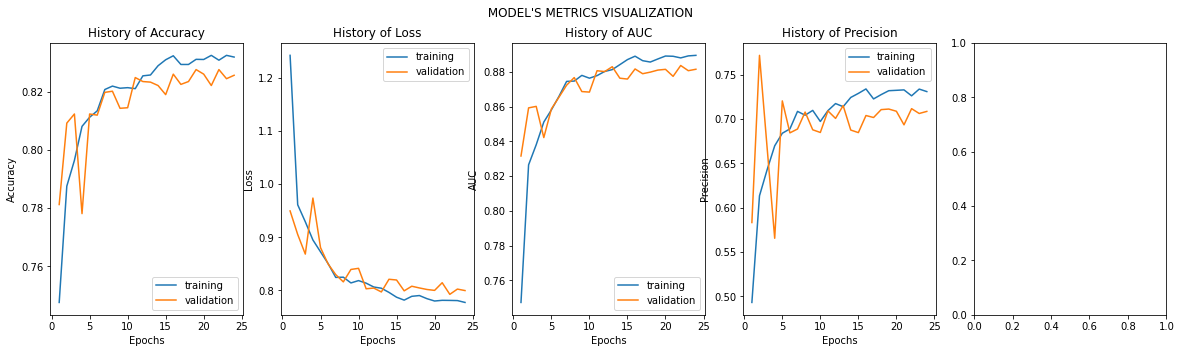

In [15]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    

    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision']              )

In [16]:
predictions=model.predict(x_test)

np.array(predictions)
CATEGORIES = ['MildDemented','ModerateDemented','NonDemented','VeryMildDemented']

2022-03-30 17:34:46.660005: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 770703360 exceeds 10% of free system memory.


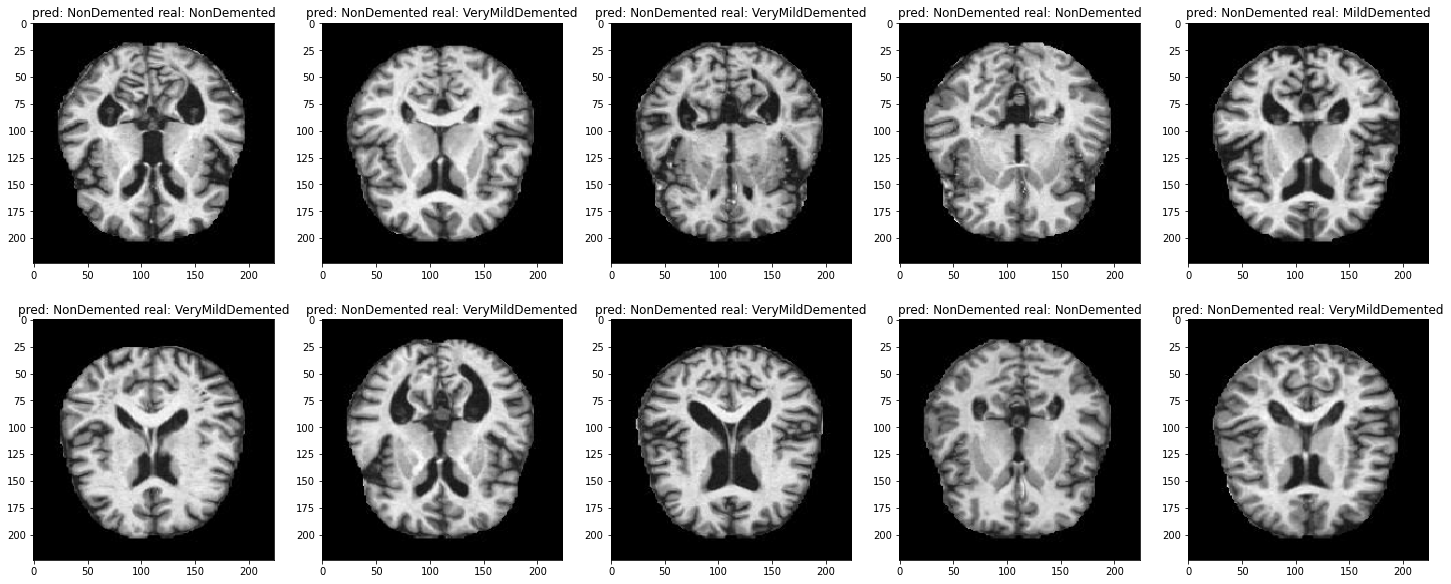

In [17]:
rows = 2
columns = 5
fig, axs= plt.subplots(rows, columns , figsize=(25, 10))
axs = axs.flatten()
i=10
for a in axs:
    
    Image = Images[indices_test[i]]
    pred_label=predictions.argmax(axis=1)[i]
    actual_label=y_test.argmax(axis=1)[i]
    pred_label=CATEGORIES[pred_label]
    actual_label=CATEGORIES[actual_label]
    label= 'pred: '+ pred_label +' '+'real: '+ actual_label
    #axs[i](rows,columns,i)
    a.imshow(np.uint8(Image))
    a.set_title(label)
    i=i+1

plt.show()

2022-03-30 17:34:52.759590: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 770703360 exceeds 10% of free system memory.


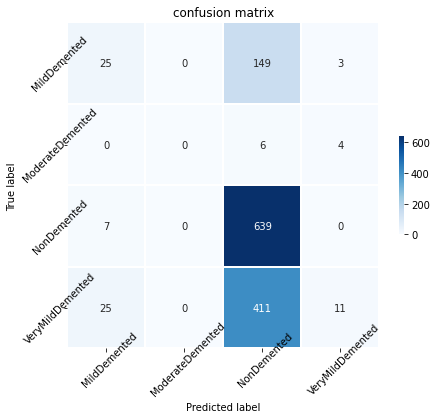

In [18]:
## plot confusion matrix
y_preds = model.predict(x_test)
y_preds = np.argmax(y_preds, axis=1)
y_trues = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [19]:
print("F1 Score (testing): %.2f%%"% (f1_score(y_trues, y_preds, average='weighted')*100.0))


F1 Score (testing): 39.45%


In [20]:
print("accuracy (testing): %.2f%%"% (accuracy_score(y_trues, y_preds)*100.0))

accuracy (testing): 52.73%


In [21]:
report = classification_report(y_trues, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.44      0.14      0.21       177
           1       0.00      0.00      0.00        10
           2       0.53      0.99      0.69       646
           3       0.61      0.02      0.05       447

    accuracy                           0.53      1280
   macro avg       0.39      0.29      0.24      1280
weighted avg       0.54      0.53      0.39      1280

